# Compare Task Overhead
Compare the difference sources of task overhead for our runs.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
runs = {
    'Baseline': Path('./prod-runs/baseline_retrain-8/'),
    'Parsl+Redis': Path('./prod-runs/parsl_retrain-8/'),
    'FuncX+Globus': Path('./prod-runs/funcx_retrain-8/'),
}

## Load in Overhead Dataframes
We stored the results of each dataframe

In [3]:
results = {}
for k, path in runs.items():
    # Get the duplicates
    with open(path / 'duplicates.json') as fp:
        dupes = json.load(fp)
    
    # Compute the mean RMSD for each run
    results[k] = pd.concat([
        pd.read_csv(Path(p) / 'processed-results' / 'overheads.csv') for p in dupes
    ])

## Get the Distribution of Times
Make sure there are not significant outliers

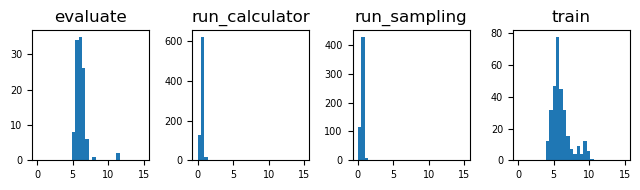

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(6.5, 2.))

for (gid, group), ax in zip(results['FuncX+Globus'].groupby('method'), axs):
    ax.hist(group['overhead_total'], bins=np.linspace(0, 15, 32))
    ax.set_title(gid)
    
fig.tight_layout()

## Make a Box Plot
Plot the overhead for each type on task for each example

Baseline [0.9193764282390476, 0.3618194577284163, 0.8015312922652811, 0.0191334796400042]
Parsl+Redis [0.47583240189798726, 0.2316571351814363, 0.2008082800041527, 0.1666285335721919]
Parsl+Redis [0.384210831, 0.1852886775, 0.148212783, 0.13374783749999997]
FuncX+Globus [5.877036369393537, 5.942722126670513, 0.6703841435335314, 0.6873358064367592]
FuncX+Globus [2.7804109544999998, 3.2626752789999998, 0.14264180699999995, 0.13438994650000002]


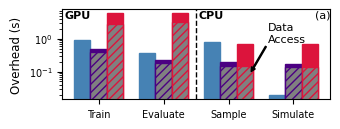

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 1.4))

width = 0.25
colors = {
    'Baseline': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

methods = ['train', 'evaluate', 'run_sampling', 'run_calculator']
for i, (name, overheads) in enumerate(results.items()):
    # Make a bar plot where we show the 
    data = [overheads.query(f'method=="{method}"')['overhead_total'].median() for method in methods]
    pos = np.arange(4) - len(results) * width / 2 + i * width
    ax.bar(pos, data, color=colors[name], edgecolor=colors[name], width=width, align='edge', label=name)
    print(name, data)
    
    if "+" in name:
        overheads['time_resolving'] = overheads['time_input_resolution'] + overheads['time_output_resolution']
        data = [overheads.query(f'method=="{method}"')['time_resolving'].median()
                for method in methods]
        ax.bar(pos, data, color='gray', edgecolor=colors[name], width=width, align='edge', hatch='////')
        print(name, data)

# Make a verical bar denoting which are remote and which are local
ax.set_yscale('log')
ax.set_ylabel('Overhead (s)')
ax.set_ylim(ax.get_ylim())
ax.plot([1.5]*2, ax.get_ylim(), 'k--', lw=1)

# Annotate what the candy-cane parts mean
ax.annotate('Data\nAccess', xy=(2.35, 0.1), xytext=(2.6, 0.8), ha='left', fontsize=8,
            arrowprops={"width": 0.75, "color": "k", "headwidth": 3, "headlength": 3})

bbox_kwargs = None # {'facecolor': 'w', 'alpha': 0.5, "boxstyle": "round, pad=0.4"}
ax.text(0.01, 0.9, 'GPU', ha='left', transform=ax.transAxes, fontweight='bold', fontsize=8, bbox=bbox_kwargs)
ax.text(0.51, 0.9, 'CPU', ha='left', transform=ax.transAxes, fontsize=8, fontweight='bold', bbox=bbox_kwargs)
ax.text(1, 1, '(a)', ha='right', va='top', transform=ax.transAxes, fontsize=8)


#fig.legend(ncol=3, fontsize=8, loc='upper center')
    
ax.set_xticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Train', 'Evaluate', 'Sample', 'Simulate'])

fig.tight_layout()
fig.savefig('figures/overhead-comparison.png', dpi=320)
fig.savefig('figures/overhead-comparison.pdf')

Display the breakdown of latency for the training tasks of Globus

In [6]:
results['FuncX+Globus'].query('method=="train"').describe()

,time_created,time_result_sent,time_running,time_input_resolution,time_output_resolution,overhead_total,overhead_sending,overhead_serialization,overhead_reporting,time_resolving
count,3.520000e+02,3.520000e+02,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,1.675852e+09,1.675852e+09,266.147362,2.231792,0.670447,9.640101,6.251793,2.385677,2.715474,2.902240
std,3.915513e+04,3.915361e+04,7.858149,0.611426,1.010772,9.197793,9.166948,0.493300,0.518996,1.182799
min,1.675802e+09,1.675802e+09,248.799223,0.151477,0.190043,4.088371,1.677210,1.752809,1.893409,0.374596
25%,1.675818e+09,1.675818e+09,260.025438,1.813566,0.251258,5.303048,2.238486,1.858355,2.210899,2.158847
50%,1.675843e+09,1.675844e+09,265.861045,2.316748,0.288578,5.877036,2.842971,2.621341,2.836554,2.780411
75%,1.675879e+09,1.675879e+09,272.185247,2.680083,0.329283,7.579575,3.195665,2.767662,3.164850,3.148907
max,1.675917e+09,1.675917e+09,283.027727,3.634134,4.195838,37.639812,31.749455,3.669856,4.225296,7.089513
